**Growth of Artificial Intelligence in the Biological Sciences (2000–2025): Semi-automated searches in PubMed**

Install libraries

In [ ]:
!pip install biopython pandas wordcloud matplotlib numpy seaborn
#simplejson, can be installed too, if you want the full texts in XML

Import necesary requirements for connect PubMed data to parse and generate plots.

In [ ]:
from Bio import Entrez
import pandas as pd
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import re
#import json si es necesario

**Define search terms**

Write your email to use Entrez. Make lists with the AI related terms and biological fields.
Gruop them in a dictionary to ease their search.

Source:

(1) Donthu 2021 *

In [ ]:
Entrez.email = "youremail@example.com"

ai_field = ["Artificial Intelligence", "Machine learning", "Deep learning"]
biofield = ["Biology", "Biomedicine", "Bioinformatics", "Genetics", "Ecology"]

dict_terms = {}
for i in biofield:
    dict_terms[i] = ai_field

print(dict_terms)

**Function 1. Query strategy**

The range count is limited query of 500 outcome per search, publication dates between 2000-2025. It returns as a list of PMIDs

Sources:

(1) Dennstädt et al. 2024

(2) https://stackoverflow.com/questions/75933779/biopython-how-can-i-increase-the-number-of-articles-found-using-entrez-esearch

In [ ]:
#Realiza búsquedas en PubMed por combinación de términos de IA +  biología encontrados en el título y resumen
def pubmed_data(terms, start_year="2000", end_year="2025", max_res=500):
  sugg = f""""{terms[0]}"[Title/Abstract] AND "{terms[1]}"[Title/Abstract] AND ({start_year}:{end_year}[dp])"""
  handle = Entrez.esearch(db="pubmed", term=sugg, retmax=max_res)
  results = Entrez.read(handle)
  handle.close()
  return results.get("IdList",[])

**Function 2. Text mining**

After getting the PMID list, metadata records are retrived in a dataset

Sources:

(1) https://github.com/TLDWTutorials/PubmedAPI/tree/main

(2) https://medium.com/@cxlwj527/scraping-and-analyzing-pubmed-data-c5fc9730

In [ ]:
def details_rec(id_list, ai_term, bio_term):
    df = pd.DataFrame(columns=['PMID', 'Title', 'Abstract', 'Year', 'MeSH_Keywords', 'URL', 'Term_List','Bio_Term'])

     #Complete XML
        #print(json.dumps(docs, indent=4, default=str))

    for pmid in id_list:
        try:
            handle = Entrez.efetch(db="pubmed", id=pmid, retmode="xml")
            docs = Entrez.read(handle)
            handle.close()

            for doc in docs['PubmedArticle']:
                paper = doc['MedlineCitation']['Article']

                title = paper['ArticleTitle']
                abstract = ' '.join(paper['Abstract']['AbstractText']) if 'Abstract' in paper and 'AbstractText' in paper['Abstract'] else 'Abstract not available'
                year = paper['Journal']['JournalIssue']['PubDate'].get('Year', 'No year found')
                #MeSH keywords
                keywords = ', '.join(keyword['DescriptorName'] for keyword in doc['MedlineCitation'].get ('MeshHeadingList', [])) or 'Keyword not found'

                url = f"https://www.ncbi.nlm.nih.gov/pubmed/{pmid}"

                pubmed_df=pd.DataFrame({
                    'PMID':[pmid],
                    'Title':[title],
                    'Abstract':[abstract],
                    'Year':[year],
                    'MeSH_Keywords': [keywords],
                    'URL': [url],
                    'Term_List': [ai_term],
                    'Bio_Term':[bio_term]})

                df = pd.concat([df,pubmed_df], ignore_index=True)

        except Exception as e:
            print(f"PMID error {pmid}: {e}")
            continue

        time.sleep(2)

    return df


**Processing Data**

Iterate each term combination from the first dictionary.
The outcome is saved in a new list, that's concated into an only dataset "all_results_df"

Sources:

(1) https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

(2) Zhu y Liu 2020 *

(3)Schotten, Plume 2020 *

In [ ]:
all_results_df = []
for bioterm, termlist in dict_terms.items():
  for ai_term in termlist:
    id_list = pubmed_data([bioterm, ai_term], start_year="2000", end_year="2025")
    time.sleep(2)
    #Con la función "details_rec", toma la lista de PMIDs, los términos de IA y de biología...
    df_result = details_rec(id_list, ai_term, bioterm)
    all_results_df.append(df_result)

if all_results_df:
    #Se verifica si hay resultados existentes. Si los hay, se agregan al nuevo dataframe
    all_results_df = pd.concat(all_results_df, ignore_index=True)
    print(all_results_df)

    #Este paso es para revisar el número total de PMIDs encontrados de todas las combinaciones
pmid_count = len(all_results_df)

print(f"\nPMID found: {pmid_count}")

*Extra*

**Data storage**

Dataset without changes is saved in .csv

In [ ]:
#Se almacena y se vuelve a leer el dataframe con los datos en crudo
all_results_df.to_csv('all_results_raw_150525.csv', index=False)
all_results_raw_df_150525 = pd.read_csv('all_results_raw_150525.csv')

**Get rid of 'em**

Remove duplicated PMIDs from raw data

In [ ]:
df_clean_150525 = all_results_raw_df_150525.drop_duplicates(subset=['PMID'])
df_clean_150525.to_csv('df_clean_150525.csv', index=False)
df_clean = pd.read_csv('df_clean_150525.csv')

**Group keywords**

'text_paper' column was made for lovin' you, also it combine keywords found in [Title/abstact].
The lists were generated to keep the MeSH and [Title/abstract] keywords.  
Stopwords were added, obtained keywords were changed to lowercase and punctuation signs were removed.


Sources:

(1) https://stackoverflow.com/questions/11858472/string-concatenation-of-two-pandas-columns

(2)https://www.w3schools.com/python/python_regex.asp

(3) https://docs.python.org/3/library/re.html

(4) Kricka et al., 2021

(5) Dennstädt et al., 2024

(6) https://stackoverflow.com/questions/63666138/how-to-find-specific-words-in-a-text-and-count-them-using-python

In [ ]:
#Se crea una nueva columna en el dF "df_clean" y se combinan los campos de títulos y resumen de los artículos
df_clean['text_paper'] = df_clean['Title'] + ' ' + df_clean['Abstract']

#Lista vacía para palabras clave de MeSH
mesh_kw = []
for keywords in df_clean['MeSH_Keywords']:
  if keywords != 'Keyword not found':
    words = [word.strip().lower() for word in keywords.split(',')]
    mesh_kw.extend(words)

stopwords=(["4", "two", "2","mi", "mrow","many", "3", "may", "best", "one", "well", "three", "will", "0", "1", "S","s","large","foundanimal", "founddeep","synthetickeyword","processingkeyword","learningkeyword", "personnelkeyword","foundkeyword","intelligencekeyword","proliferationkeyword", "foundhumans", "available", "keywords", "found","no", "not", "keyword"]) + list(STOPWORDS)

##Lista vacía para almacenar las palabras clave de Títle/Abstract "TiAB"
TiAb_kw = []
for text_p in df_clean['text_paper']:
  #Las palabras que se obtengan estarán en minúsculas y se eliminarán signos de puntuación
  text_p = text_p.lower()
  text_p = re.sub(r'[^\w\s]', ' ', text_p)
  words = text_p.split()
  words = [word for word in words if word and word not in stopwords]
  TiAb_kw.extend(words)

# Se combinan ambas listas de palabras clave
all_kwlist = mesh_kw +  TiAb_kw

**Keyword frequency counting**

Using module Counter from Collections library, the most common keywords within the count are analyzed.

Source:

(1) https://www.geeksforgeeks.org/python-most_common-function/

In [ ]:
#Se contean las palabras claves existentes en "all_kwlist"
kw_counter = Counter(all_kwlist)

#De todas las palabras clave, se tomarán sólo 77 palabras que más se repiten
frequent_kw = kw_counter.most_common(77)
print("\nFrequent keywords:")
for keyword, frequency in frequent_kw:
  print(f"{keyword}: {frequency}")

**Chart 1**

Barplot with 15 most frequent keywords found in MeSH and [Title/Abstract]


Sources:

(1) https://stackoverflow.com/questions/11371204/unpack-the-first-two-elements-in-list-tuple

(2) Chen 2017 *

In [ ]:
plt.figure(figsize=(15, 10))
#Se seleccionan 15 palabras más frecuentes para poderlas graficar junto con su frecuencia
keywords = [keyword for keyword, _ in frequent_kw[:15]]
frequencies = [frequency for _, frequency in frequent_kw[:15]]

sns.barplot(x=frequencies, y=keywords, palette='Blues_d', hue=keywords, legend=False)
plt.title('Common keywords found in Artificial Intelligence associated with Biological Sciences', fontsize=18, y=1.00)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Keywords', fontsize=14)
plt.tight_layout()
plt.savefig('common_keywords.png', dpi=300)

plt.show()

**Create a dictionary to keywords**

WordCloud library can't interpret tuples structures from "frequent_kw"

In [ ]:
kw_dict = dict(frequent_kw)

**Chart 2. Generate a Wordcloud**

Through '.generate_from_frequencies()' keyword dictionary was add in this way to create a wordcloud with words and frequencies

Source:

(1)  https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

(2) https://amueller.github.io/word_cloud/auto_examples/frequency.html

In [ ]:
wordcloud_freq = WordCloud(max_words=100, stopwords=stopwords, width=1600, height=800, background_color="black", max_font_size=150, collocations=True).generate_from_frequencies(kw_dict)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_freq.recolor(colormap='tab20b'),interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=1.08)
plt.savefig('wordcloud_freq.png', dpi=300)
plt.show()

**Data conversion**

This part was necessary, becase it convert the column 'Years' string to numeric so data can be plotted and year distribution was distributed. Also the AI terms were changed to string.


Sources:

(1) https://stackoverflow.com/questions/61815267/how-do-i-transform-a-pandas-groupby-with-a-condition-on-the-transformation

(2) https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/

In [ ]:
#La columna de "Year" se convierte a númerico para posteriormente sean filtrados entre 2000 y 2025
df_clean['Year']=pd.to_numeric(df_clean['Year'], errors='coerce')
df_clean = df_clean[(df_clean['Year'] >= 2000) & (df_clean['Year'] <= 2025)]

#Este paso es para examinar la distribución de los artículos por año
year_distribution=df_clean.groupby(["Year"]).size()
print("Distribution:")
print(year_distribution)

#En un nuevo dataframe donde agrupan los datos como los términos de búsqueda de la IA y de biología. Y se cuentan cuántos términos existen.
df_clean['Term_List']=df_clean['Term_List'].astype(str)
df_bar = df_clean.groupby(['Bio_Term', 'Term_List']).size().reset_index(name='Count')

print(df_clean)

**Chart 3. Publication counts AI vs Biology fields**

From 'df_bar', barplot is generated, it shows the total publication found in each combination search term between AI and biology fields

Sources:

(1) https://python-graph-gallery.com/basic-barplot-with-seaborn/

(2) https://www.delftstack.com/es/howto/python-pandas/pandas-column-contains-string/?utm_source=chatgpt.com

(3) https://github.com/modin-project/modin/issues/847

(4) https://www.kaggle.com/code/valeriamulina/bank-customers-categorization-clustering?scriptVersionId=139180478

In [ ]:
plt.figure(figsize=(18, 8))
#Para la gráfia de barras, en el eje "x", se agregan los campos biológicos y en el eje "y", se agrega el conteo.
ax=sns.barplot(x='Bio_Term', y='Count', hue='Term_List', data=df_bar, palette='Blues_d')

plt.title('Publications of Artificial Intelligence in the biological sciences (2000-2025)', fontsize=20, y= 1.05)
plt.xlabel('Biological Field', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=0, fontsize=12)

#Se anotan los valores a cada una de las barras
for p in ax.patches:
  ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=13)

plt.tight_layout()
plt.savefig('barplot_count.png', dpi=300)
plt.show()

**Chart 4. Total of AI mentions in biological sciences**

From 'yearly_counts' to show year distribution. In 'summary_df', 'Term_List' and 'Count' were added, in this way to identify the use of AI in biofields

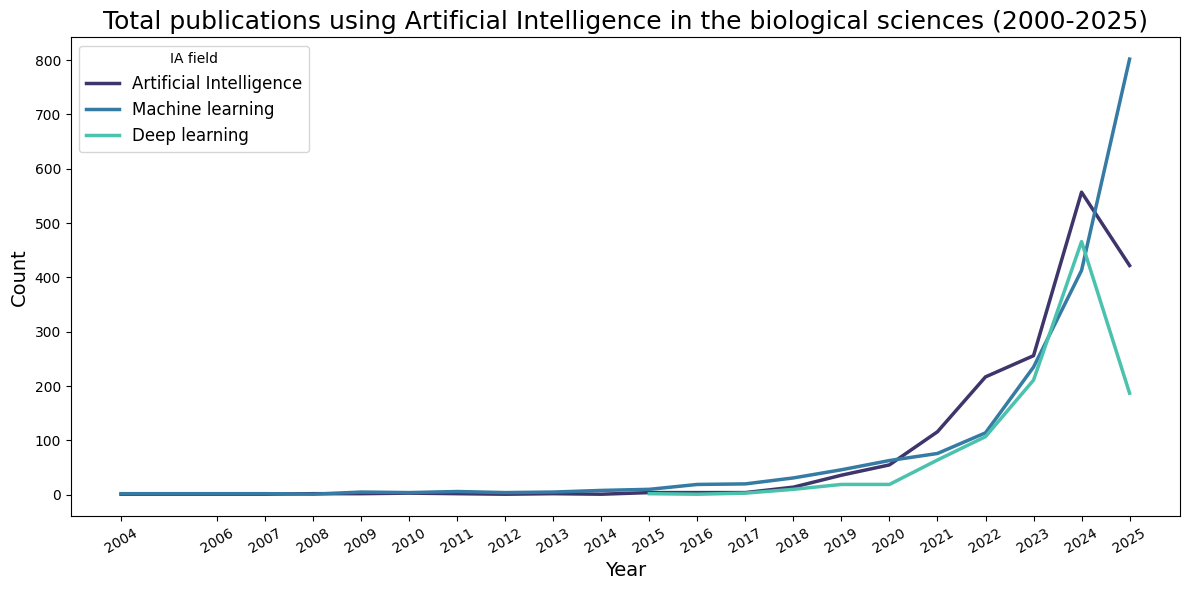

In [ ]:
#En este dF, se toma "yearly_counts" el cuál se vuelve a reagrupar tomando sólo el año y el área de la IA
summary_df = yearly_counts.groupby(['Year', 'Term_List'])['Count'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Count', hue='Term_List', data=summary_df, markers= True, dashes=False, linewidth=2.5, palette='mako')


plt.title("Total publications using Artificial Intelligence in the biological sciences (2000-2025)", fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(sorted(df_clean['Year'].unique()), rotation=30)
plt.legend(title='IA field', fontsize=12)

plt.tight_layout()
plt.savefig("total_pub", dpi=300)
plt.show()

Bibliografía

(1) Dennstädt, F., Zink, J., Putora, P. M., Hastings, J., & Cihoric, N. (2024). Title and abstract screening for literature reviews using large language models: an exploratory study in the biomedical domain. Systematic Reviews, 13(1). https://doi.org/10.1186/s13643-024-02575-4

(2) Donthu 2021, How to conduct a bibliometric analysis: an overview and guidelines

(3) Zhu y Liu 2020. A tale of two databases: the use of web science and scopus

(4) Schotten, Plume 2020. Scopus as curated, high-quality bibliometric data source for academic research

(5) Natukunda, A., & Muchene, L. K. (2023). Unsupervised title and abstract screening for systematic review: a retrospective case-study using topic modelling methodology. Systematic Reviews, 12(1). https://doi.org/10.1186/s13643-022-02163-4

(7) Chen 2017. Science mapping: a systematic review of literature